In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
data = pd.read_csv("employee_data.csv")

# 1. Data quality check
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64


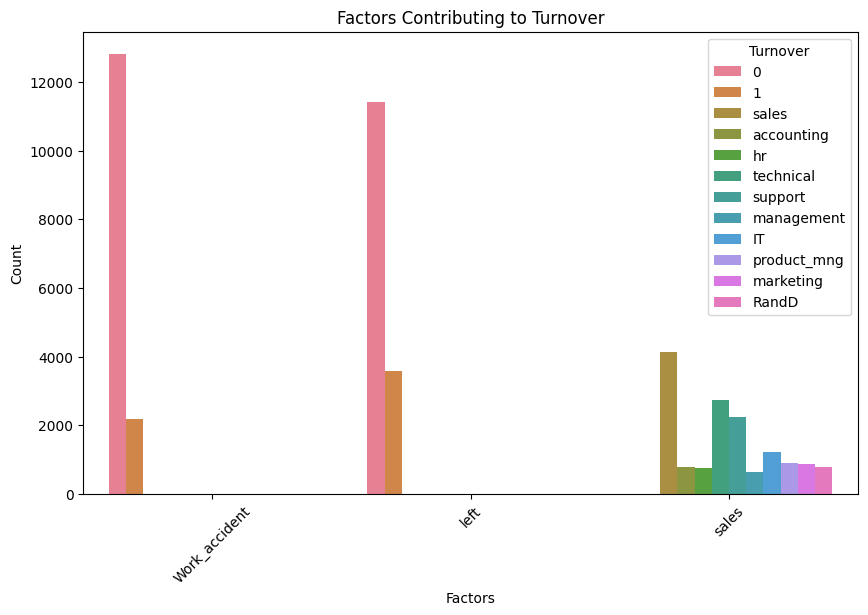

In [8]:
# 2. Exploratory Data Analysis (EDA)
# Understanding factors contributing to turnover
turnover_factors = data.drop(columns=['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'promotion_last_5years', 'salary'])
plt.figure(figsize=(10,6))
sns.countplot(x='variable', hue='value', data=pd.melt(turnover_factors))
plt.title("Factors Contributing to Turnover")
plt.xlabel("Factors")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Turnover")
plt.show()

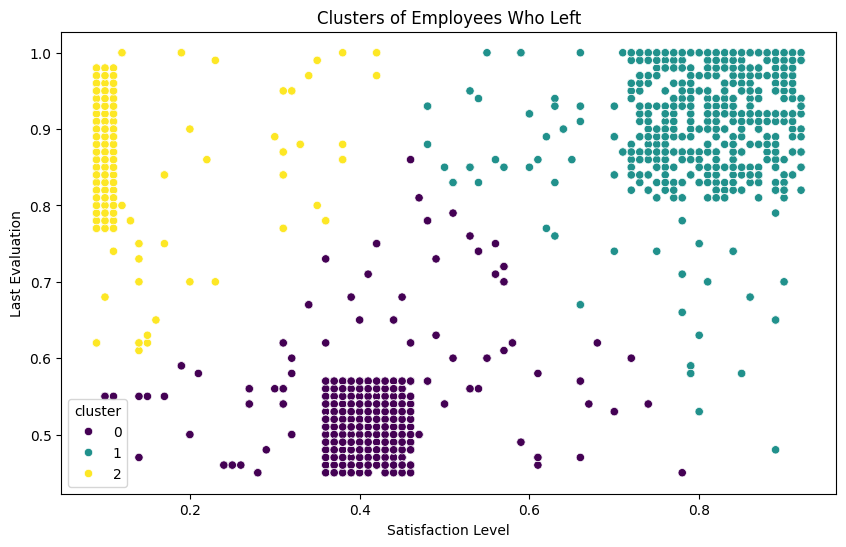

In [9]:
# 3. Clustering of Employees who left based on their satisfaction and evaluation
left_employees = data[data['left'] == 1][['satisfaction_level', 'last_evaluation']]
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(left_employees)
left_employees['cluster'] = kmeans.labels_

plt.figure(figsize=(10,6))
sns.scatterplot(data=left_employees, x='satisfaction_level', y='last_evaluation', hue='cluster', palette='viridis')
plt.title("Clusters of Employees Who Left")
plt.xlabel("Satisfaction Level")
plt.ylabel("Last Evaluation")
plt.show()

In [10]:
# 4. Handling class imbalance using SMOTE
X = data.drop('left', axis=1)
y = data['left']

In [11]:
# Convert categorical variables to numerical using one-hot encoding
X = pd.get_dummies(X)

In [12]:
# SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [13]:
# 5. Perform k-fold cross-validation model training and evaluate performance
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# 6. Model training and evaluation
rf_classifier = RandomForestClassifier(random_state=42)
params = {'n_estimators': [100, 200, 300],
          'max_depth': [None, 5, 10, 15]}
grid_search = GridSearchCV(rf_classifier, params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train_scaled, y_train)
y_pred = best_rf_model.predict(X_test_scaled)

# 7. Model evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9857830271216098
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2323
           1       0.99      0.98      0.99      2249

    accuracy                           0.99      4572
   macro avg       0.99      0.99      0.99      4572
weighted avg       0.99      0.99      0.99      4572

Confusion Matrix:
[[2309   14]
 [  51 2198]]


In [17]:
# Feature Importance
feature_importance = pd.Series(best_rf_model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False, inplace=True)
print("Feature Importance:")
print(feature_importance)

Feature Importance:
satisfaction_level       0.268311
time_spend_company       0.214612
average_montly_hours     0.154010
number_project           0.152667
last_evaluation          0.130495
Work_accident            0.021104
salary_low               0.011168
salary_medium            0.007068
salary_high              0.007034
sales_technical          0.006606
sales_sales              0.005248
sales_support            0.005160
sales_hr                 0.003019
sales_IT                 0.002535
sales_RandD              0.002318
promotion_last_5years    0.002123
sales_accounting         0.002071
sales_management         0.001596
sales_marketing          0.001429
sales_product_mng        0.001424
dtype: float64
